In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data_dir = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage"  # path to the 15-class dataset

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load entire dataset
full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

# Split: 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
class_names = full_dataset.classes

print(f"Classes ({len(class_names)}): {class_names}")


Classes (15): ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False  # freeze pretrained layers

# Replace classifier for 15 classes
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ekadw/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [5]:
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    preds_all, labels_all = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())
    
    acc = correct / total
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | "
          f"Val Acc: {acc:.4f}")

Epoch 1/10 | Train Loss: 0.8146 | Val Loss: 0.3985 | Val Acc: 0.9026
Epoch 2/10 | Train Loss: 0.3741 | Val Loss: 0.2949 | Val Acc: 0.9145
Epoch 3/10 | Train Loss: 0.2955 | Val Loss: 0.2597 | Val Acc: 0.9210
Epoch 4/10 | Train Loss: 0.2580 | Val Loss: 0.2326 | Val Acc: 0.9305
Epoch 5/10 | Train Loss: 0.2318 | Val Loss: 0.2166 | Val Acc: 0.9344
Epoch 6/10 | Train Loss: 0.2194 | Val Loss: 0.2051 | Val Acc: 0.9370
Epoch 7/10 | Train Loss: 0.2063 | Val Loss: 0.2023 | Val Acc: 0.9351
Epoch 8/10 | Train Loss: 0.1989 | Val Loss: 0.2031 | Val Acc: 0.9351
Epoch 9/10 | Train Loss: 0.1880 | Val Loss: 0.1945 | Val Acc: 0.9373
Epoch 10/10 | Train Loss: 0.1801 | Val Loss: 0.2069 | Val Acc: 0.9300


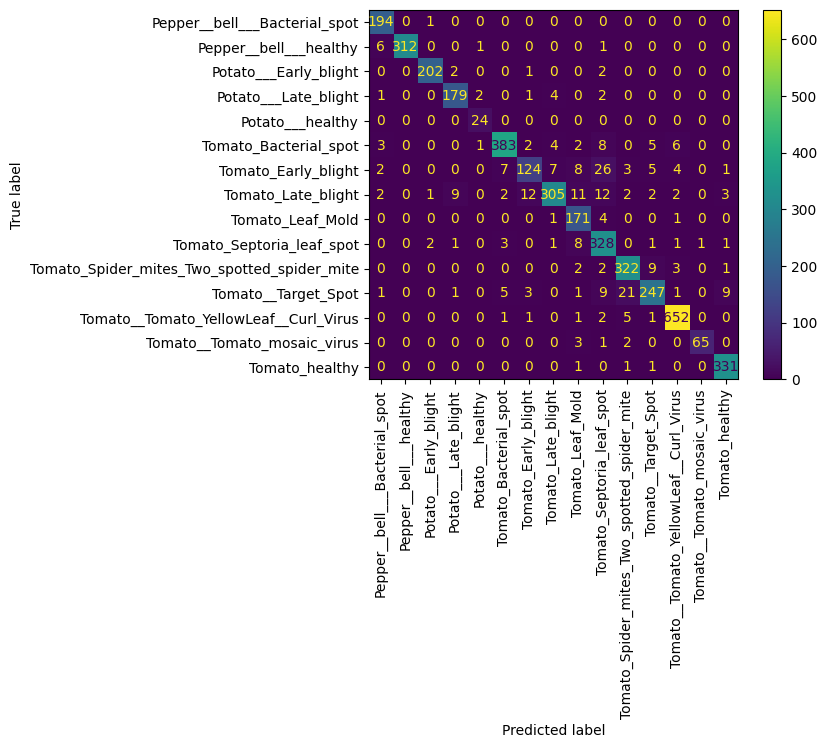

In [6]:
cm = confusion_matrix(labels_all, preds_all)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=90, cmap='viridis')
plt.show()

In [8]:
from PIL import Image

img_path = "C:/Users/ekadw/Documents/DATA/Leaf_Disease/PlantVillage/Potato___Early_blight/0a0744dc-8486-4fbb-a44b-4d63e6db6197___RS_Early.B 7575.jpg"
img = Image.open(img_path)
img_t = val_transforms(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(img_t)
    pred = torch.argmax(output, 1).item()

print(f"Predicted class: {class_names[pred]}")


Predicted class: Potato___Early_blight
